In [1]:
import numpy as np
import scipy
import cmath

import matplotlib.pyplot as plt

In [2]:
## Setup some matrices
I = np.eye(2)
O = np.zeros((2,2))

pi = np.pi

In [3]:
## Properties of air
rho = 1.225
u = np.arange(1,150,1)
#u = np.sqrt(1.4*287*273)*np.arange(0.001,1,0.001)

In [4]:
## Estimate of NASA BSCW data
omega_a = 100
omega_h = 100

c = 1
t = 0.06*c
l = 2

b = c/2
xf = 0.5*c
a = xf-0.5*c
mu = 60
m = mu*c*t*l
S = -m*a
e = xf/c-0.25
ra = np.sqrt(0.87)
Ia = ra*ra*m*b*b

In [5]:
kh = 10000
ka = 8700

## Unsteady Wagner

In [6]:
## Define Wagner functions
psi1 = 0.165
psi2 = 0.335
eps1 = 0.0455
eps2 = 0.30

#  Hardcoded for t=0
#  Actual: psi = lambda v,t: 1-psi1*np.exp(-eps1*v*t/b)-psi2*np.exp(-eps2*v*t/b)
#          psidot = lambda v,t: psi1*eps1*v/b*np.exp(-eps1*v*t/b)+psi2*eps2*v/b*np.exp(-eps2*v*t/b)

psi0 = 1.0-psi1-psi2
psidot0 = lambda v: psi1*eps1*v/b+psi2*eps2*v/b

In [7]:
## Make empty storage arrays
uspitch = []
usheave = []
uspdamp = []
ushdamp = []

In [8]:
## Loop through each airspeed
for i in range(len(u)):
    ## Assembly
    U = u[i]
    
    M = np.array([
        [m+rho*pi*b*b,          S-rho*pi*b*b*(xf-c/2)],
        [S-rho*pi*b*b*(xf-c/2), Ia+rho*pi*b*b*(xf-c/2)**2+0.125*b*b]
    ])
    C = rho*pi*U*c*np.array([
        [psi0,      c/4+psi0*(3*c/4-xf)],
        [-e*c*psi0, (3*c/4-xf)*(c/4-e*c*psi0)]
    ])
    K = np.array([
        [kh+rho*pi*U*c*psidot0(U),     rho*pi*U*c*(U*psi0+(3*c/4-xf)*psidot0(U))],
        [-rho*pi*U*e*(c**2)*psidot0(U), ka-rho*pi*U*e*(c**2)*(U*psi0+(3*c/4-xf)*psidot0(U))]
    ])
    W = 2*rho*pi*U*U*U*np.array([
        [-psi1*(eps1**2)/b,    -psi2*(eps2**2)/b,    psi1*eps1*(1-eps1*(1-2*e)),      psi2*eps2*(1-eps2*(1-2*e))],
        [e*c*psi1*(eps1**2)/b, e*c*psi2*(eps2**2)/b, -e*c*psi1*eps1*(1-eps1*(1-2*e)), -e*c*psi2*eps2*(1-eps2*(1-2*e))]
    ])
    
    ## Construct Q
    Qtop = np.concatenate((-np.linalg.solve(M,C),-np.linalg.solve(M,K),-np.linalg.solve(M,W)),axis=1)
    Qmid = np.concatenate((I,O,O,O),axis=1)
    Qbtm = np.array([
        [0,0,1,0,-eps1*U/b,0,0,0],
        [0,0,1,0,0,-eps2*U/b,0,0],
        [0,0,0,1,0,0,-eps1*U/b,0],
        [0,0,0,1,0,0,0,-eps2*U/b]
    ])
    Q = np.concatenate((Qtop,Qmid,Qbtm),axis=0)
    
    val = np.linalg.eigvals(Q)
    cpvals = sorted(val, key=lambda x:x.imag)
    
    uspitch.append(abs(cpvals[0])/2/pi)
    uspdamp.append(-cpvals[0].real/abs(cpvals[0]))
    usheave.append(abs(cpvals[1])/2/pi)
    ushdamp.append(-cpvals[1].real/abs(cpvals[1]))

In [9]:
## Convert all to numpy arrays
uspitch = np.array(uspitch)
usheave = np.array(usheave)
uspdamp = np.array(uspdamp)
ushdamp = np.array(ushdamp)

## P-K with Theodorsen function

In [10]:
## Define Theodorsen function
C = lambda k: 1-0.165/(1-(0.0455/k)*1j)-0.355/(1-(0.3/k)*1j)

In [11]:
## Make empty storage arrays
pkpitch = []
pkheave = []
pkpdamp = []
pkhdamp = []

In [12]:
PK_M = np.array([
    [m,S],
    [S,Ia]
])
PK_K = np.array([
    [kh,0],
    [0,ka]
])
PK_D = rho*pi*b*b*np.array([
    [-1, a],
    [a,  -(a**2+b**2)/8]
])

omegas = np.array([omega_a,omega_h])

In [13]:
## Loop through each airspeed
for i in range(len(u)):
    U = u[i]
    K = (b/U)*omegas #reduced frequency
    
    ## Select the nth degree of freedom
    for n in range(len(K)):
        k = K[n]
        
        # Start while loop for convergence
        omega_old = omegas[n]
        conv = 1e-6
        err = 1
        count = 1
        
        while abs(err) > conv:
            PK_E = rho*pi*b*U*np.array([
                [-2*C(k),      2*C(k)*(a-b/2)-b],
                [(2*a+b)*C(k), -(b**2-a*b+(2*a+b)*(a-b/2)*C(k))]
            ])
            PK_F = rho*pi*b*U*U*C(k)*np.array([[0,-2],[0,2*a+b]])
            PK_A = np.concatenate((
                np.concatenate((O,I),axis=1),
                np.concatenate((np.linalg.solve(PK_M-PK_D,PK_F-PK_K),np.linalg.solve(PK_M-PK_D,PK_E)),axis=1)
            ),axis=0)
            
            PKvals = np.linalg.eigvals(PK_A)
            PKvals = sorted(PKvals,key=lambda x:x.imag,reverse=True)
            
            omega_new = PKvals[n].imag
            
            err = abs(abs(omega_old)-abs(omega_new))/omegas[n]
            k = omega_new*b/U
            omega_old = omega_new
            count = count+1
            
            if count > 1000:
                break
                
        #end while
        if n==1:
            pkheave.append(abs(PKvals[n])/2/pi)
            pkhdamp.append(-PKvals[n].real/abs(PKvals[n]))
        else:
            pkpitch.append(abs(PKvals[n])/2/pi)
            pkpdamp.append(-PKvals[n].real/abs(PKvals[n]))

In [14]:
## Convert all to numpy arrays
pkpitch = np.array(pkpitch)
pkheave = np.array(pkheave)
pkpdamp = np.array(pkpdamp)
pkhdamp = np.array(pkhdamp)

## Check flutter

In [15]:
def check_flutter(damping1,damping2):
    c = 0    #c=1 indicates pitch mode flutter
    idx = 0
    for n in range(len(damping1)-1):
        z_next = damping1[n+1]
        z_this = damping1[n]
        if z_this>1e-6:
            if z_next/z_this<0:
                idx = n+1
                c = 1
                break
    if c==0:
        for n in range(len(damping2)-1):
            z_next = damping2[n+1]
            z_this = damping2[n]
            if z_this>1e-6:
                if z_next/z_this<0:
                    idx = n+1
                    break
    return idx,c

In [16]:
print('Using unsteady Wagner function...')
idx,c = check_flutter(uspdamp,ushdamp)
if idx:
    usfspd = u[idx]
    if c:
        usfreq = uspitch[idx]
    else:
        usfreq = usheave[idx]
    print(f'Test frequency is {omega_a/2/pi} Hz')
    print(f'Unsteady flutter speed is {usfspd} m/s')
    print(f'Unsteady flutter freq. is {usfreq} Hz')
else:
    print(f'Test frequency is {omega_a/2/pi} Hz')
    print(f'No flutter observed in range')
    
print('Using P-K with Theodorsen function...')
idx,c = check_flutter(pkpdamp,pkhdamp)
if idx:
    pkfspd = u[idx]
    if c:
        pkfreq = pkpitch[idx]
    else:
        pkfreq = pkheave[idx]
    print(f'Test frequency is {omega_a/2/pi} Hz')
    print(f'Unsteady flutter speed is {pkfspd} m/s')
    print(f'Unsteady flutter freq. is {pkfreq} Hz')
else:
    print(f'Test frequency is {omega_a/2/pi} Hz')
    print(f'No flutter observed in range')

Using unsteady Wagner function...
Test frequency is 15.915494309189533 Hz
Unsteady flutter speed is 68 m/s
Unsteady flutter freq. is 10.163582300373424 Hz
Using P-K with Theodorsen function...
Test frequency is 15.915494309189533 Hz
Unsteady flutter speed is 91 m/s
Unsteady flutter freq. is 9.270804377016246 Hz


## Validation

Text(0.5, 0.98, 'Supercritical wing')

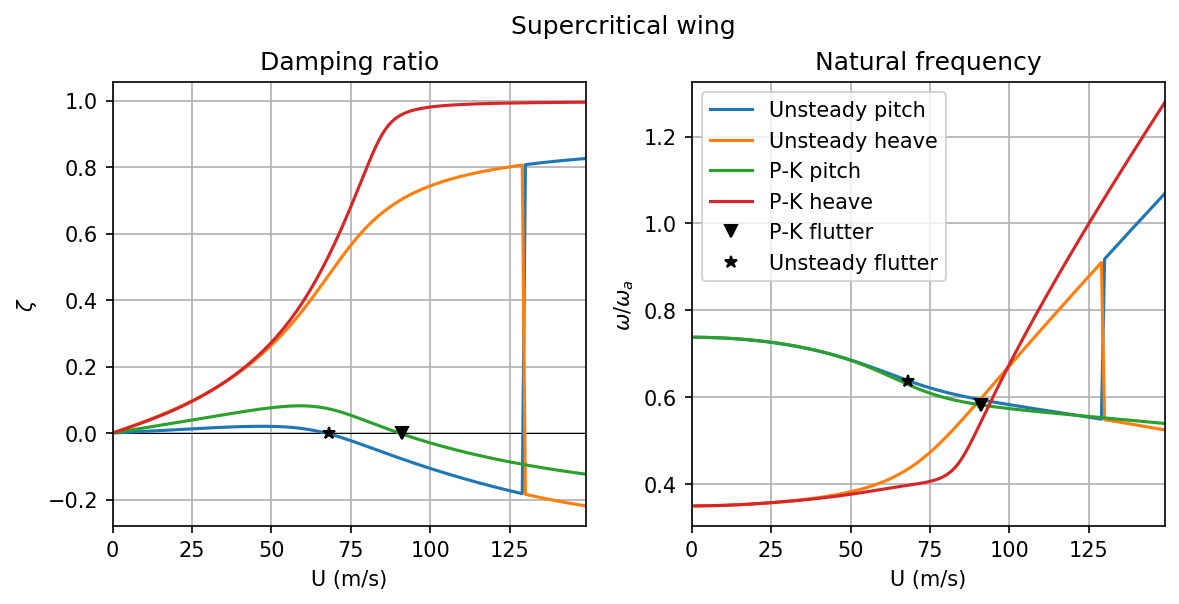

In [17]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
fig.set_dpi(150)
fig.tight_layout(pad=2,rect=(0,0,1,0.95))

ax[0].axhline(y=0,color='k',linewidth=0.5)
ax[0].plot(u,uspdamp,label='Unsteady pitch')
ax[0].plot(u,ushdamp,label='Unsteady heave')
ax[0].plot(u,pkpdamp,label='P-K pitch')
ax[0].plot(u,pkhdamp,label='P-K heave')

ax[0].set_xlim([0,max(u)])
ax[0].set_xlabel("U (m/s)")
ax[0].set_ylabel("$\zeta$")
ax[0].grid()

ax[1].plot(u,uspitch/(omega_a/2/pi),label='Unsteady pitch')
ax[1].plot(u,usheave/(omega_a/2/pi),label='Unsteady heave')
ax[1].plot(u,pkpitch/(omega_a/2/pi),label='P-K pitch')
ax[1].plot(u,pkheave/(omega_a/2/pi),label='P-K heave')
ax[1].set_xlim([0,max(u)])
ax[1].set_xlabel("U (m/s)")
ax[1].set_ylabel("$\omega/\omega_a$")
ax[1].grid()

try:
    ax[0].plot(pkfspd,0,'kv',label='P-K flutter')
    ax[0].plot(usfspd,0,'k*',label='Unsteady flutter')
    ax[1].plot(pkfspd,pkfreq/(omega_a/2/pi),'kv',label='P-K flutter')
    ax[1].plot(usfspd,usfreq/(omega_a/2/pi),'k*',label='Unsteady flutter')
except:
    pass

ax[0].set_title('Damping ratio')
#ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[1].set_title('Natural frequency')

fig.suptitle('Supercritical wing')